# **Non-negative Matrix Factorization - An Implementation and Experimentation**
### CSC 466-1 Knowledge Discovery from Data, Winter 2020 - Final Project
#### Andrew Kesheshian, Griffin Johnson, Quinn Coleman

## **Background**
Non-negative matrix factorization (NMF) is an unsupervised machine learning technique created by [Lee & Seung](http://www.columbia.edu/~jwp2128/Teaching/E4903/papers/nmf_nature.pdf) in 1999. It is a versatile algorithm because of its ability to make a parts-based-representation of its input data. What enables this parts-based-representation is the constraint that NMF's input data must be quantitative with no negative values. 

### **How it Works**
Given a non-negative matrix ***V*** of dimension *f* ✕ *t*, the algorithm learns two non-negative matrices: ***W*** of dimension *f* ✕ *k* and ***H*** of dimension *k* ✕ *t*, where k < minimum(f,t). ***W*** and ***H*** are approximate factors of ***V***, thus when they are multiplied together, they create an approximation of the original matrix called ***V'***.

- ***V*** is the original data
    - t columns of f-dimensional data
    - Each column is a sample, each row is a feature
- ***W*** is the basis vectors (or dictionary matrix)
    - A linear combination of these approximates any sample in V
    - Each column is called a basis vector
- ***H*** is the activations
    - Each activation encodes a linear combination of all basis vectors, and corresponds to a sample in V
    - Each column is called an activation (or weight or gain)

To put it simply, basis vectors are like the building blocks to create any sample in our input data, and an activation tells us how much of each building block to use to recreate a sample.

![NMF](NMF.png)

Figure by Qwertyus - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=29114677

NMF has many uses. It can naturally be used for data compression and approximation - if k is small enough, like k = 2 in the figure above, ***W*** and ***H*** take up less space than the original data ***V***. It also has data-specific uses like source-seperation for audio data or topic extraction for textual data. A use of NMF we'll explore is **dimensionality reduction**. 

### **Dimensionality Reduction**
Dimensionality reduction is the task of taking a dataset with many dimesions (or features), and transforming it into a dataset with fewer dimensions while losing the least amount of information possible.

We already learned a dimensionality reduction technique in class: Principal Components Analysis (PCA). The principal components (PCs) in PCA describe the axes orthogonal to each other that run in the direction of greatest variance in the data. Thus, these principal components can describe the data in lower dimension.

![PCA](PCA.png)

Figure by https://medium.com/@TheDataGyan/dimensionality-reduction-with-pca-and-t-sne-in-r-2715683819

Like the principal components of PCA, the basis vectors of NMF accomplish the same thing. If you think about it, basis vectors in the linear algebra sense are unit vectors that describe a vector space. To "describe a vector space" means any possible vector can be made with a linear combination of these basis vectors. Principal components are like specifically-designed basis vectors for losing the least amount of information possible. For example, in the figure above, if a dataset is being dimension-reduced by only 1 dimension, information will be lost but only on the axis of least variance (PC1 and PC2 are the axes of greatest variance).

So in NMF, as long we choose a k-value that is less than the number of dimensions in our dataset, we'll create k basis vectors, and reduce our dataset down to k dimensions. Since each datapoint in a dimension-reduced dataset is a linear combination of basis vectors, our dimension-reduced dataset is simply the matrix ***H***.

## **Implementation**
In order to make NMF, we frame an optimization problem. This optimization problem is about minimizing the distance/error from the product ***WH*** to ***V***. The implementation of NMF we are using is derived from a specific distance measurement called Kullback-Leibler (KL) Divergence. KL Divergence mathematically allows us to create two multiplicative update formulas, one for each of the matrices: ***W*** and ***H***.

In this algorithm, ***W*** and ***H*** are initialized to random-valued matrices in an unsupervised manner, and ***V*** is input. Then, for a predetermined number of iterations (usually 100-200 until convergence), the multiplicative updates are applied to ***W*** and ***H*** in succession until their matrix product doesn't approximate the original data any much better with continuing iterations. The figure below sums up this algorithm as "KL-NMF".

![NMF learn loop](NMF_Learn_Loop.png)

Figure by https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf

For dimensionality reduction, one more step to take is to normalize the basis vector matrix after initialization and each update. This normalization insures that the basis vectors remain unit vectors, as the only thing that matters is their orientation. With that said, let's code this below. We'll put this algorithm inside the primary method of our NMF class.

In [1]:
import numpy as np
from sklearn.preprocessing import normalize


class OurNMF:
    def __init__(self, n_components, learn_iter=200):
        self.n_components_ = n_components
        self.learn_iter_ = learn_iter
        
    # Private method - core functionality
    def __nmf(self, input_df):
        input_matrix = input_df.to_numpy().T
        activations = np.random.rand(self.n_components_, input_matrix.shape[1])
        basis_vectors = np.random.rand(input_matrix.shape[0], self.n_components_)
        basis_vectors = normalize(basis_vectors)
        ones = np.ones(input_matrix.shape)
    
        for i in range(self.learn_iter_):
            activations *= ((basis_vectors.T @ (input_matrix / (basis_vectors @ activations))) / (basis_vectors.T @ ones))
            basis_vectors *= (((input_matrix / (basis_vectors @ activations)) @ activations.T) / (ones @ activations.T))
            
            activations = np.nan_to_num(activations)
            basis_vectors = np.nan_to_num(basis_vectors)
#             print(basis_vectors.dtype)
#             print(True in np.isnan(basis_vectors))
#             print(True in np.isinf(basis_vectors))
            
            basis_vectors = normalize(basis_vectors)
            
        return basis_vectors.T, activations.T
    
    # Public methods
    # Useless function - similar to scikit-learn, but call fit_transform to get transformed values back
    def fit(self, input_df):
        self.basis_vecs_, self.trans_vals_ = self.__nmf(input_df)
        
    def fit_transform(self, input_df):
        self.basis_vecs_, self.trans_vals_ = self.__nmf(input_df)
        return self.trans_vals_


## **Validate our Implementation**
Let's validate our implementation of NMF by comparing its results with the NMF method provided by a trusted and widely-used machine learning library.

This library is called [scikit-learn](https://scikit-learn.org/stable/) and its NMF documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html).

***Note -- Scikit-Learn Documentation Error:***
On the NMF documentation page, variable names *W* and *H* are swapped which can be very **misleading**. They call *W* the transformed data, and *H* the factorization matrix (dictionary elements). In reality, *W* is this factorization matrix, and *H* is the transformed data *(no documentation is perfect, even for scikit-learn)*.

#### **Dataset Creation**
To begin, let's make a dataset for our NMFs. We use another python library, [pandas](https://pandas.pydata.org/), to handle datasets.

In [2]:
import pandas as pd

dummy_data = [{'A': 1.00, 'B': 'K', 'C': 3, 'D': 9, 'E': 43.76, 'ans': 1},
              {'A': 0.99, 'B': 'L', 'C': 3, 'D': 8, 'E': 43.45, 'ans': 0},
              {'A': 0.54, 'B': 'M', 'C': 0, 'D': 23, 'E': 54.65, 'ans': 1},
              {'A': 1.00, 'B': 'M', 'C': 0, 'D': 12, 'E': 40.15, 'ans': 0},
              {'A': 0.32, 'B': 'L', 'C': 1, 'D': 12, 'E': 89.04, 'ans': 1},
              {'A': 0.43, 'B': 'L', 'C': 4, 'D': 11, 'E': 49.04, 'ans': 0},
              {'A': 0.99, 'B': 'M', 'C': 1, 'D': 10, 'E': 34.54, 'ans': 0}]

dummy_df = pd.DataFrame(dummy_data)
# Transform categorical features ('B') into quantitative ones ('K', 'L', 'M') via get_dummies (one-hot encoding)
quant = pd.get_dummies(dummy_df['B'])
labels = dummy_df['ans']
dummy_df = dummy_df.drop('B', axis=1).drop('ans', axis=1)
dummy_df = pd.concat((dummy_df, quant, labels), axis=1)
dummy_df

,A,C,D,E,K,L,M,ans
0,1.00,3,9,43.76,1,0,0,1
1,0.99,3,8,43.45,0,1,0,0
2,0.54,0,23,54.65,0,0,1,1
3,1.00,0,12,40.15,0,0,1,0
4,0.32,1,12,89.04,0,1,0,1
5,0.43,4,11,49.04,0,1,0,0
6,0.99,1,10,34.54,0,0,1,0


#### **Comparison**
A good way to see if our NMF works is by performing a common use case for dimensionality reduction: visualizing data.

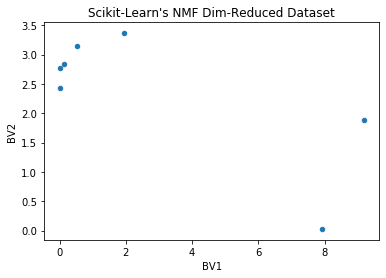

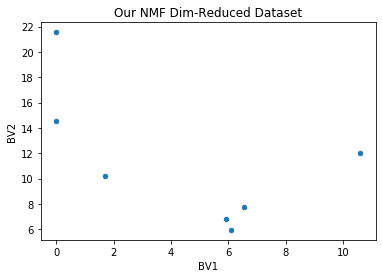

In [3]:
%matplotlib inline
from sklearn.decomposition import NMF

sklearn_nmf = NMF(n_components=2, init='random', solver='mu', beta_loss='kullback-leibler')
our_nmf = OurNMF(n_components=2)

sklearn_trans_df = pd.DataFrame(sklearn_nmf.fit_transform(dummy_df), columns=['BV1', 'BV2'])
our_trans_df = pd.DataFrame(our_nmf.fit_transform(dummy_df), columns=['BV1', 'BV2'])

# display(sklearn_trans_df)
# display(our_trans_df)

sklearn_trans_df.plot.scatter(x='BV1', y='BV2', title='Scikit-Learn\'s NMF Dim-Reduced Dataset')
our_trans_df.plot.scatter(x='BV1', y='BV2', title='Our NMF Dim-Reduced Dataset')

This is great, our NMF works! 🎉🎉 Since the data on both charts look similar, it seems that both our and scikit-learn's NMF find the same way to represent this data in lower dimension.

*Note -- if you don't see a similarity between plots and the axes look flipped:* Run the previous code cell 1-2 more times until they match. This happens because in NMF each basis vector equally contributes to recreating the dataset, so their ordering isn't meaningful, thus not needing consistency. We just want to see when the two basis vectors from our NMF is in the same order as scikit-learn NMF's two basis vectors - when this happens, the transformed values corresponding to a basis vector will appear on the same axis as the other chart's axis.

## **Experimentation**

#### Notes
#### To-fill-in next:
- Experimentation = Comparisons of our NMF to PCA
    - 1) Compare prediction performance between a weak classifer given NMF-dim-reduced data & a weak classifier given PCA-dim-reduced data (synthetic dataset)
        - analysis: observe the differences in performance, and maybe see if NMF is better or worse than PCA for this use-case
    - 2) Make a Pearson correlation matrix between NMF and PCA on BVs/PCs and/or transformed values
        - analysis: see if NMF and PCA is correlated (hopefully not - casue theyre different methods)
    - ? 3) Compare visualization of data when we do NMF and PCA on titanic dataset to bring it down to 2 dimensions for charting (scatter plots)
        - analysis: see if NMF or PCA visualizes the titanic data better, or maybe if one's better at visualizing previously-quantitative (i.e. pclass) / quantitative (i.e. age) features than the other

#### **Use Case: Resolving the Curse of Dimensionality**
Too Many Dimensions for a Weak Classifier. Let's begin by pre-processing a real dataset into quantitative, non-negative form. We'll be sure to fill in missing values, and scale our data so that no features with large values unfairly skew the learning of our classifier.

In [4]:
from sklearn.preprocessing import MinMaxScaler

titanic_df = pd.read_csv(
    "https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv"
)

titanic_df = titanic_df.drop("name", axis=1)
titanic_df = titanic_df.drop("ticket", axis=1)

# 0) filling missing data
titanic_df = titanic_df.replace([np.inf, -np.inf], np.nan)
titanic_df["age"] = titanic_df["age"].fillna(value=titanic_df["age"].mean())
titanic_df["fare"] = titanic_df["fare"].fillna(value=0.0)

# 1) Scale the quantitative vars
quant_feat = ["age", "sibsp", "parch", "fare"]
scaler = MinMaxScaler()
quant_titanic_df = titanic_df[quant_feat]
quant_titanic_df = pd.DataFrame(scaler.fit_transform(quant_titanic_df), columns=quant_feat)

titanic_df = titanic_df.drop(quant_feat, axis=1)
titanic_df = pd.concat((titanic_df, quant_titanic_df), axis=1)

# 2) Encode catagorical variables to quantitative variables
catagorical_to_quantitative_maps = {}

# pclass
pclass_quant = pd.get_dummies(titanic_df["pclass"])
pclass_quant["pclass 1"] = pclass_quant[1]
pclass_quant = pclass_quant.drop(1, axis=1)
pclass_quant["pclass 2"] = pclass_quant[2]
pclass_quant = pclass_quant.drop(2, axis=1)
pclass_quant["pclass 3"] = pclass_quant[3]
pclass_quant = pclass_quant.drop(3, axis=1)
titanic_df = titanic_df.drop('pclass', axis=1)
titanic_df = pd.concat((titanic_df, pclass_quant), axis=1)

# gender
catagorical_to_quantitative_maps["sex"] = list(titanic_df["sex"].unique())
gender_catagories = pd.DataFrame(pd.get_dummies(titanic_df["sex"]))
titanic_df = titanic_df.drop("sex", axis = 1)
titanic_df= pd.concat([titanic_df, gender_catagories], axis = 1)
   
# boat
titanic_df["boat"] = titanic_df["boat"].fillna(value="No boat")
catagorical_to_quantitative_maps["boat"] = list(titanic_df["boat"].unique())
boat_catagories = pd.DataFrame(pd.get_dummies(titanic_df["boat"]))
titanic_df = titanic_df.drop("boat", axis = 1)
titanic_df = pd.concat([titanic_df, boat_catagories], axis = 1)
# adjust a few columns to aviod running into problems when creating a column with the same name
# will need to consider this when going backwards
titanic_df["boat C"] = titanic_df["C"]
titanic_df = titanic_df.drop("C", axis=1)
catagorical_to_quantitative_maps["boat"].append("boat C")
catagorical_to_quantitative_maps["boat"].remove("C")
titanic_df["boat D"] = titanic_df["D"]
titanic_df = titanic_df.drop("D", axis=1)
catagorical_to_quantitative_maps["boat"].append("boat D")
catagorical_to_quantitative_maps["boat"].remove("D")

#cabin
catagorical_to_quantitative_maps["cabin"] = list(titanic_df["cabin"].unique())
cabins = pd.DataFrame(pd.get_dummies(titanic_df["cabin"]))
titanic_df = titanic_df.drop("cabin", axis = 1)
titanic_df = pd.concat([titanic_df, cabins], axis = 1)

#embarked
titanic_df["embarked"] = titanic_df["embarked"].fillna(value="entrance unknown")
catagorical_to_quantitative_maps["embarked"] = list(titanic_df["embarked"].unique())
entrances = pd.DataFrame(pd.get_dummies(titanic_df["embarked"]))
titanic_df = titanic_df.drop("embarked", axis = 1)
titanic_df = pd.concat([titanic_df, entrances], axis = 1)

#body
titanic_df["body"] = titanic_df["body"].fillna(value="body unknown")
catagorical_to_quantitative_maps["body"] = list(titanic_df["body"].unique())
bodies = pd.DataFrame(pd.get_dummies(titanic_df["body"]))
titanic_df = titanic_df.drop("body", axis = 1)
titanic_df = pd.concat([titanic_df, bodies], axis = 1)

#home.dest
titanic_df["home.dest"] = titanic_df["home.dest"].fillna(value="home.dest unknown")
catagorical_to_quantitative_maps["home.dest"] = list(titanic_df["home.dest"].unique())
destinations = pd.DataFrame(pd.get_dummies(titanic_df["home.dest"]))
titanic_df = titanic_df.drop("home.dest", axis = 1)
titanic_df = pd.concat([titanic_df, destinations], axis = 1)

# Put class labels on the end
survived = titanic_df['survived']
titanic_df = titanic_df.drop('survived', axis=1)
titanic_df = pd.concat((titanic_df, survived), axis=1)

display(titanic_df.shape)
titanic_df.head()

(1309, 720)

,age,sibsp,parch,fare,pclass 1,pclass 2,pclass 3,female,male,1,...,"Winnipeg, MB","Winnipeg, MN","Woodford County, KY","Worcester, England","Worcester, MA","Yoevil, England / Cottage Grove, OR","Youngstown, OH","Zurich, Switzerland",home.dest unknown,survived
0,0.361169,0.000,0.000000,0.412503,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.009395,0.125,0.222222,0.295806,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0.022964,0.125,0.222222,0.295806,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.373695,0.125,0.222222,0.295806,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.311064,0.125,0.222222,0.295806,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's do ourselves a NMF non-negativity constraint sanity check, and see if we have any negative values in our dataset.

In [5]:
print('Number of neg vals:', (titanic_df < 0).sum().sum())

Number of neg vals: 0


Nope! So, now let's make this dataset hard for a classifier by using a small amount of samples, and adding many unimportant features - these are essentially noise for a classifier.

In [6]:
n_samples = 200
Xy = titanic_df.sample(frac=1.0)[:n_samples]
Xy.index = range(n_samples)

# 3) Put random vars in (already in min-max scale range)
noise = pd.DataFrame(np.random.random(size=(n_samples, 2000)), columns=['noise_f' + str(x) for x in range(2000)])
Xy = pd.concat((noise, Xy), axis=1)

X = Xy.drop('survived', axis=1)
y = Xy['survived']

display(Xy.shape)
Xy.head()

X.isnull().sum().sum()

(200, 2720)

0

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Problem: simple classifiers like linear regression handle poorly with datasets that have:
# - massive dimension (feature count) compared to sample size
# - few important features

pred_iterations = 30
accs = []
logreg_model = LogisticRegression()
for _ in range(pred_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    logreg_model.fit(X_train, y_train)
    y_pred = logreg_model.predict(X_test)
    
    acc_score = accuracy_score(y_pred, y_test)
    accs.append(acc_score)

print('Logistic Regression Avg Accuracy Score (Bad):', np.mean(accs))

Logistic Regression Avg Accuracy Score (Bad): 0.8253333333333334


In [ ]:
from sklearn.decomposition import PCA
# Solution: simple classifiers can handle these datasets better, after dimensionality reduction is applied
# If we reduce dimensions on a dataset via NMF & sklearn PCA, and then predict at each dimension drop, does lin. reg. performance increase?
min_dim = 2
dim_nmf_accs, dim_pca_accs = [], []

# Track how prediction performance differs with amount of dimensions
# num of dim must be <= min dimension of our X for sklearn NMF
for dim_num in range(min_dim, min(X.shape) + 1, 10): 

    # Perform PCA and NMF on same dataset
    nmf_model = OurNMF(n_components=dim_num)
    X_nmftrans = pd.DataFrame(nmf_model.fit_transform(X))
    
    pca_model = PCA(n_components=dim_num)
    X_pcatrans = pd.DataFrame(pca_model.fit_transform(X))
    
    nmf_accs, pca_accs = [], []
    for _ in range(pred_iterations):

        X_train, X_test, y_train, y_test = train_test_split(X_nmftrans, y)
        logreg_model.fit(X_train, y_train)
        y_pred = logreg_model.predict(X_test)
        nmf_accs.append(accuracy_score(y_pred, y_test))
        
        X_train, X_test, y_train, y_test = train_test_split(X_pcatrans, y)
        logreg_model.fit(X_train, y_train)
        y_pred = logreg_model.predict(X_test)
        pca_accs.append(accuracy_score(y_pred, y_test))

    dim_nmf_accs.append(np.mean(nmf_accs))
    dim_pca_accs.append(np.mean(pca_accs))
    
nmf_logreg_accs = pd.Series(dim_nmf_accs)
pca_logreg_accs = pd.Series(dim_pca_accs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in matmul


In [ ]:
index = range(min_dim, min(X.shape) + 1, 10)
nmf_logreg_accs.index = index
pca_logreg_accs.index = index

nmf_logreg_accs.plot.line(title='LogReg Accuracy for PCA and NMF Dim-Reduced Data', legend=True, label='NMF', figsize=(15,8))
ax = pca_logreg_accs.plot.line(legend=True, label='PCA')
ax.set_xlabel("Dimensions")